In [1]:
import numpy as np
import pandas as pd
import openpyxl
import matplotlib as mp
import matplotlib.pyplot as plt
import sklearn as sl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [2]:
# Load the Excel file
file_path = "C:/Users/ganes/OneDrive/Desktop/AI/Drug/Sequence/Sequence_Filtered_Cleaned.xlsx"
df = pd.read_excel(file_path)


# Define features and target AFTER encoding
X = df[['Chromosome_Encoded', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Gene_ID', 'Transcript_ID']]
y = df['RPKM']  

# Split into train (80%) and test (20%)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.2, random_state=42)

Train MAE: 4.355389365933562
Test MAE: 4.773326721765575
Train RMSE: 16.028884970394802
Test RMSE: 23.040382743641324
Train R²: 0.9778029881033854
Test R²: 0.9529682107917894
Best estimator: DecisionTreeRegressor(max_depth=15, min_samples_split=5, random_state=42)


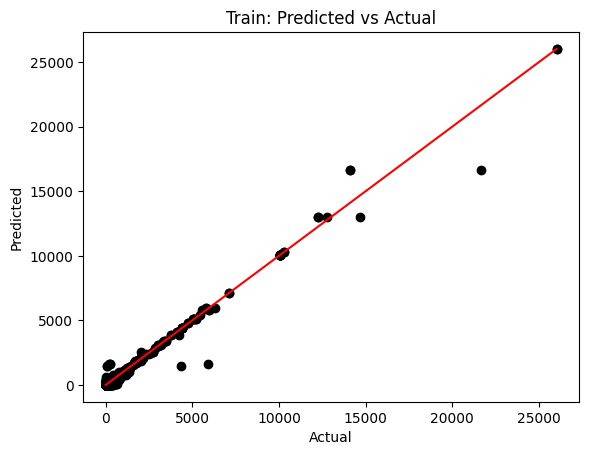

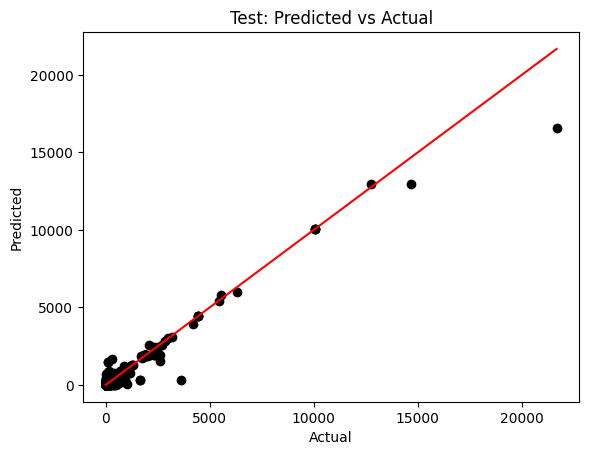

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import math

# Expanded hyperparameter grid to control overfitting
hyper_params_dt = {
    'min_samples_split': [2, 5, 10, 20],
    'max_depth': [5, 10, 15, None],  # Adding depth control
    'min_samples_leaf': [1, 5, 10]  # Minimum samples per leaf to reduce overfitting
}

# Define and fit the model
np.random.seed(22)
DT = DecisionTreeRegressor(random_state=42)
g_search_DT = RandomizedSearchCV(DT, hyper_params_dt, cv=10, n_jobs=-1, n_iter=10)
dt_model = g_search_DT.fit(X_Train, Y_Train)

# Make predictions
predict_dt_train = g_search_DT.predict(X_Train)
predict_dt_test = g_search_DT.predict(X_Test)

# Calculate metrics
mae_dt_train = mean_absolute_error(Y_Train, predict_dt_train)
mae_dt_test = mean_absolute_error(Y_Test, predict_dt_test)

mse_dt_train = mean_squared_error(Y_Train, predict_dt_train)
mse_dt_test = mean_squared_error(Y_Test, predict_dt_test)

r2_dt_train = r2_score(Y_Train, predict_dt_train)
r2_dt_test = r2_score(Y_Test, predict_dt_test)

# Print performance metrics
print(f"Train MAE: {mae_dt_train}")
print(f"Test MAE: {mae_dt_test}")
print(f"Train RMSE: {math.sqrt(mse_dt_train)}")
print(f"Test RMSE: {math.sqrt(mse_dt_test)}")
print(f"Train R²: {r2_dt_train}")
print(f"Test R²: {r2_dt_test}")

# Best estimator
print("Best estimator:", g_search_DT.best_estimator_)

# Plot scatter for training data
plt.scatter(Y_Train, predict_dt_train, marker='o', alpha=1, color="black")
plt.plot([min(Y_Train), max(Y_Train)], [min(Y_Train), max(Y_Train)], color="red")
plt.title("Train: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Plot scatter for test data
plt.scatter(Y_Test, predict_dt_test, marker='o', alpha=1, color="black")
plt.plot([min(Y_Test), max(Y_Test)], [min(Y_Test), max(Y_Test)], color="red")
plt.title("Test: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


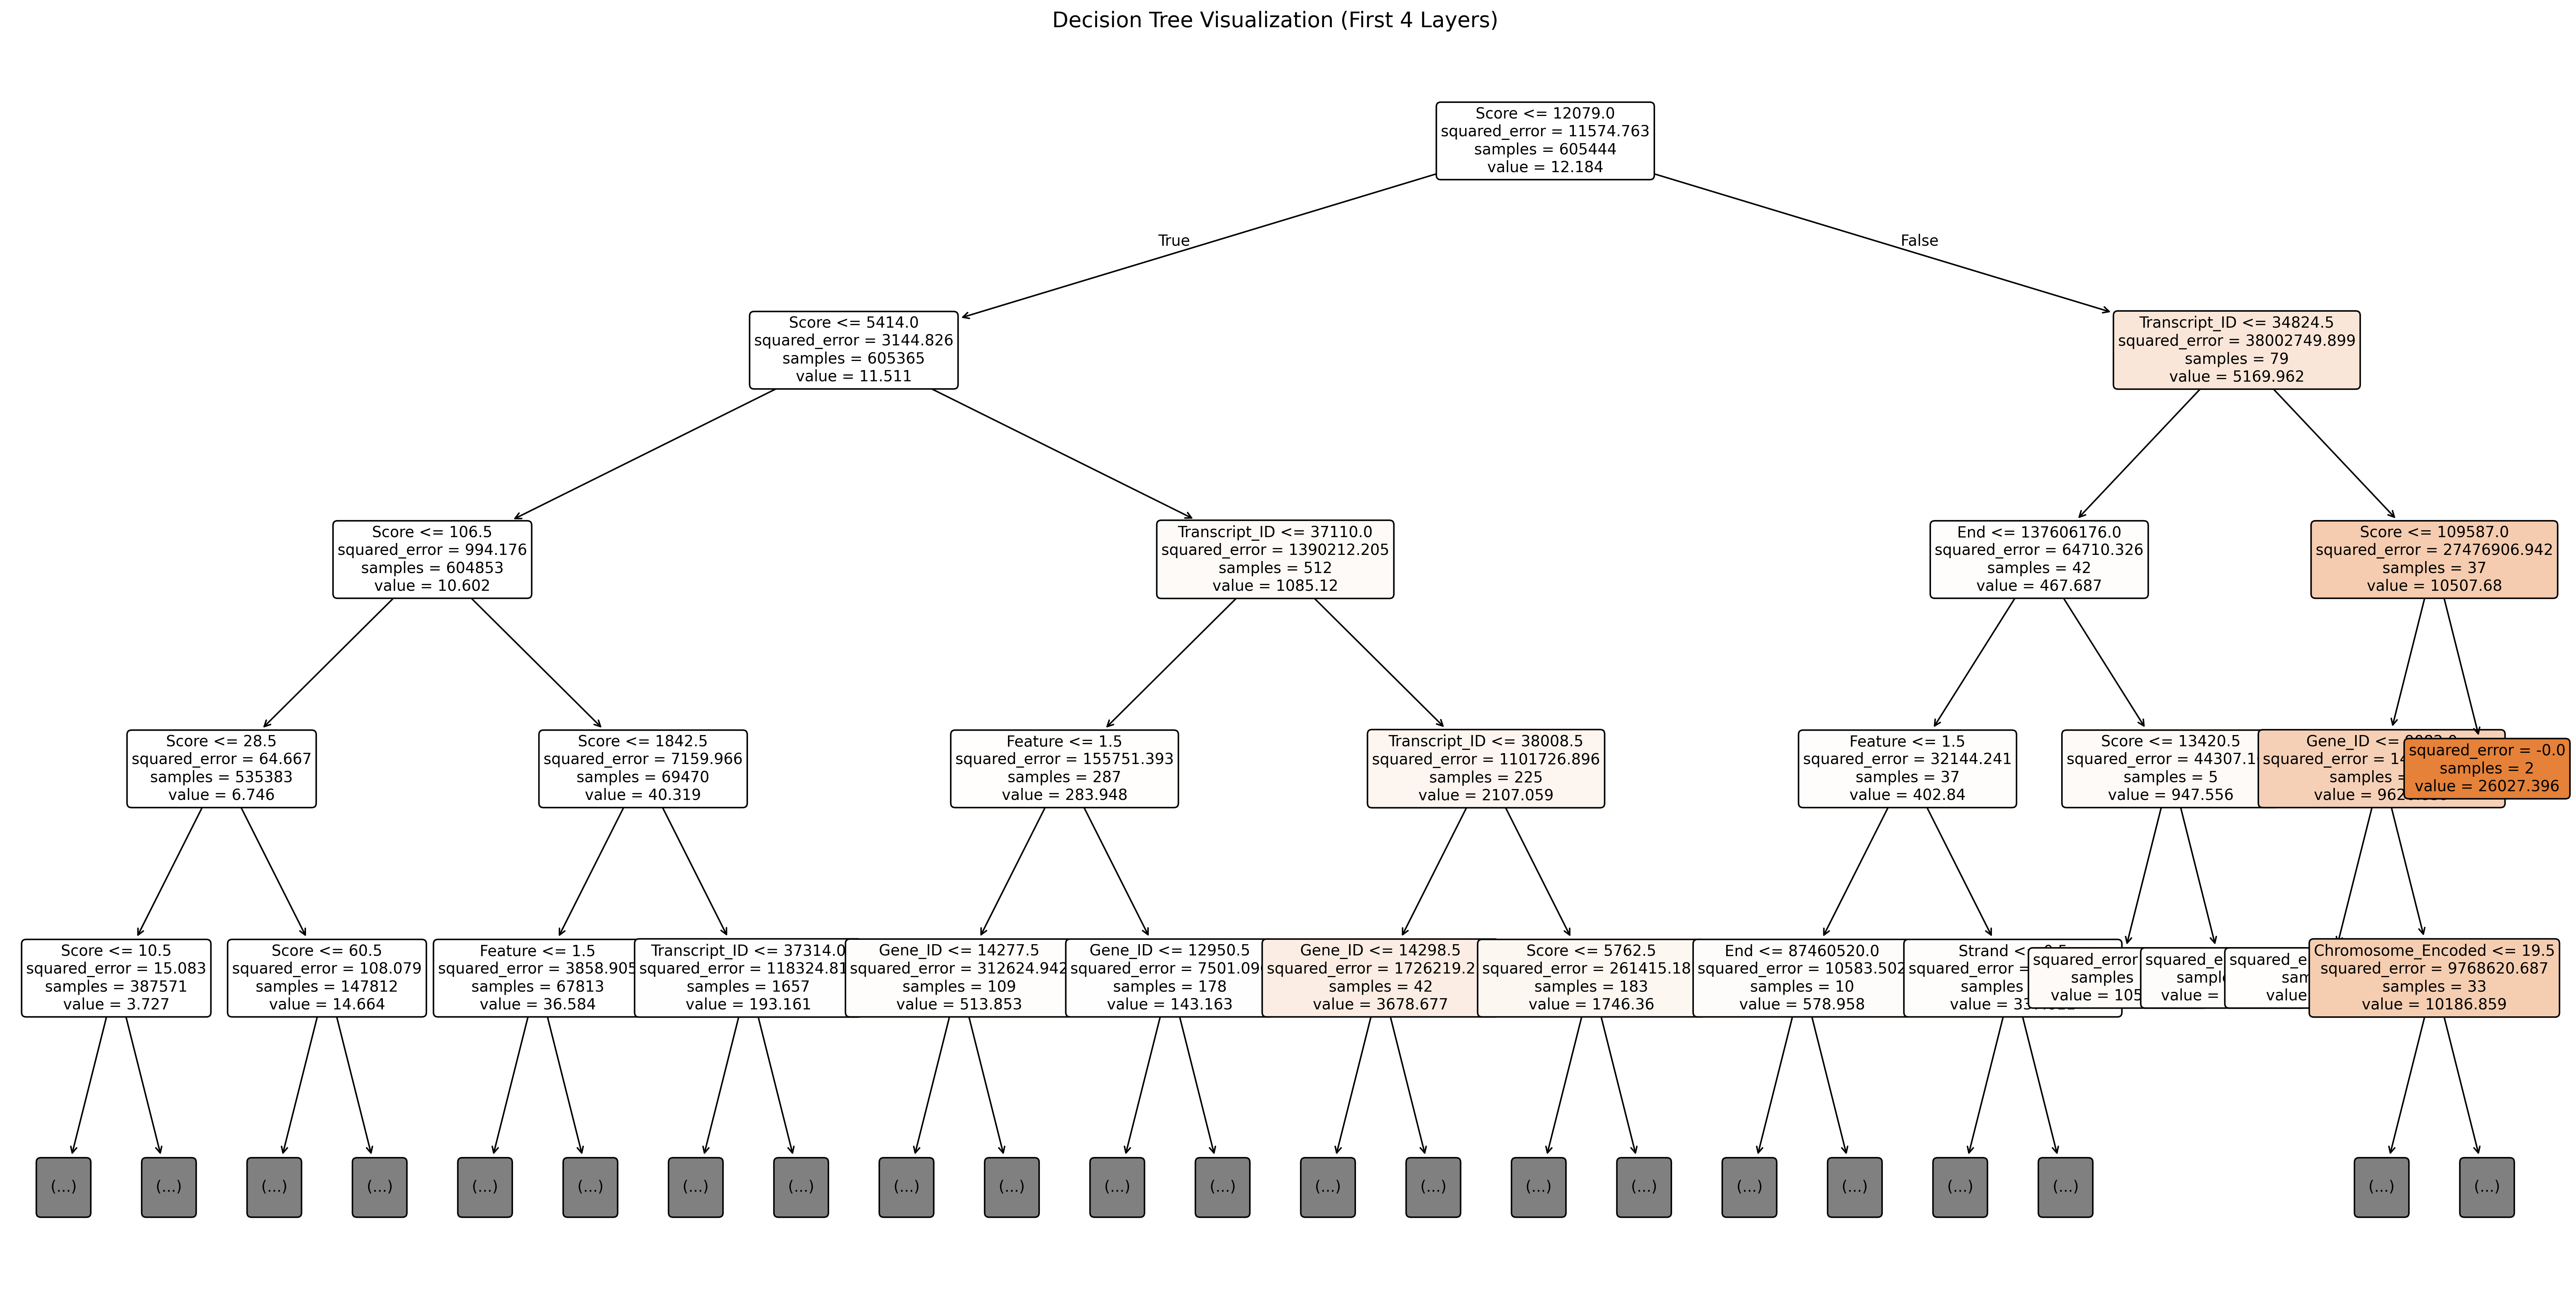

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the best estimator from RandomizedSearchCV
best_dt = g_search_DT.best_estimator_

# Increase figure size for better readability
plt.figure(figsize=(30, 15), dpi=300)

# Reduce font size and limit depth to avoid clutter
plot_tree(best_dt, 
          filled=True, 
          feature_names=X_Train.columns, 
          max_depth=4,  # Try increasing depth slightly
          fontsize=10, 
          rounded=True)

# Save as high-resolution image for clarity
plt.title("Decision Tree Visualization (First 4 Layers)", fontsize=14)
plt.savefig("decision_tree_improved.png", dpi=400, bbox_inches='tight')
plt.show()


              Feature  Importance
4               Score    0.511403
7       Transcript_ID    0.391055
6             Gene_ID    0.045641
0  Chromosome_Encoded    0.030164
1             Feature    0.010354
2               Start    0.009044
3                 End    0.001666
5              Strand    0.000673


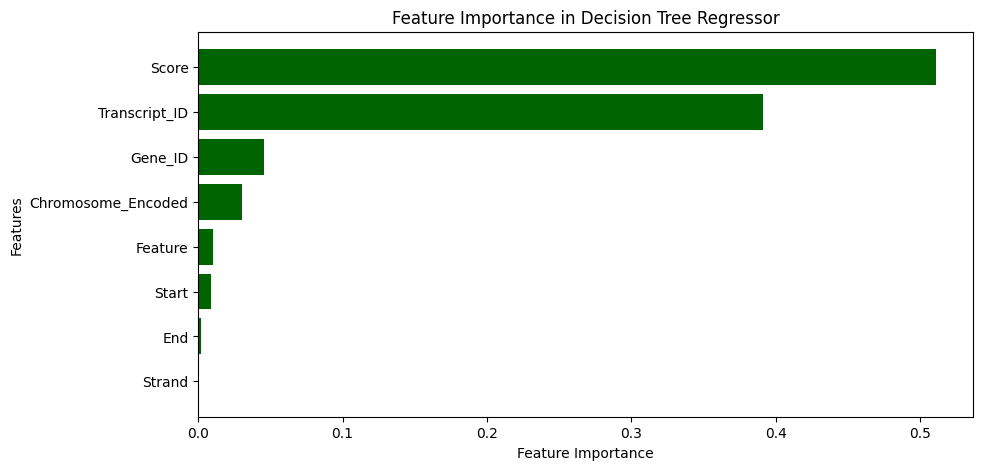

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance from the best estimator
best_dt = g_search_DT.best_estimator_
feature_importance_dt = best_dt.feature_importances_

# Create a DataFrame for sorting
feat_importance_df_dt = pd.DataFrame({"Feature": X_Train.columns, "Importance": feature_importance_dt})
feat_importance_df_dt = feat_importance_df_dt.sort_values(by="Importance", ascending=False)  # Sort in descending order

# Print feature importance
print(feat_importance_df_dt)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df_dt["Feature"], feat_importance_df_dt["Importance"], color='darkgreen')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree Regressor")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


Train MAE: 5.1246358377568955
Test MAE: 5.362025871868689
Train RMSE: 20.183203267943767
Test RMSE: 29.784814667761083
Train R²: 0.9648060446712472
Test R²: 0.9214037317157026
Best estimator: RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42)


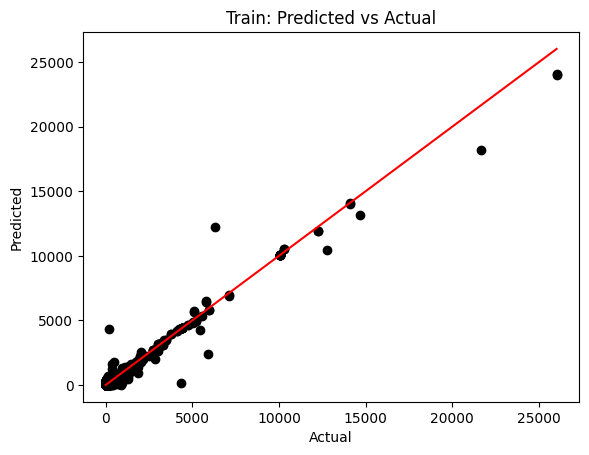

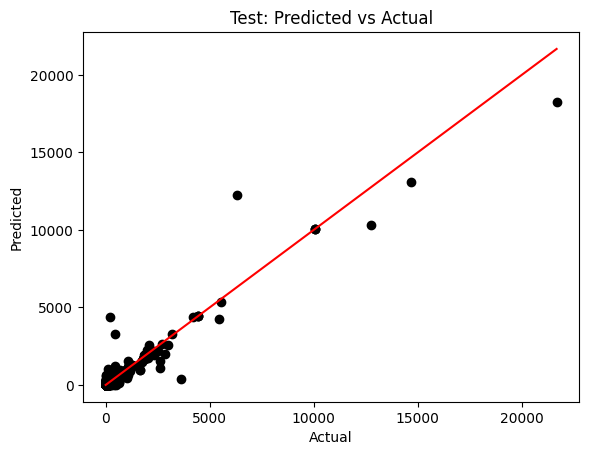

In [3]:
# Hyperparameter grid without 'auto'
hyper_params_rdf = {'n_estimators': [100, 300],   # Reduce choices
    'max_depth': [10, 30],        # Remove `None`
    'min_samples_split': [2, 10], # Keep only min/max
    'min_samples_leaf': [1, 4]}
    
# Define and fit the model
np.random.seed(22)
RF = RandomForestRegressor(random_state=42,)
g_search_RF = RandomizedSearchCV(RF, hyper_params_rdf, cv=10, n_jobs=-1, n_iter=2)
rf_model = g_search_RF.fit(X_Train, Y_Train)

# Make predictions
predict_rf_train = g_search_RF.predict(X_Train)
predict_rf_test = g_search_RF.predict(X_Test)

mae_rf_train = mean_absolute_error(Y_Train, predict_rf_train)
mae_rf_test = mean_absolute_error(Y_Test, predict_rf_test)

# Print MAE
print(f"Train MAE: {mae_rf_train}")
print(f"Test MAE: {mae_rf_test}")

# Calculate and print metrics
mse_rf_train = mean_squared_error(Y_Train, predict_rf_train)
mse_rf_test = mean_squared_error(Y_Test, predict_rf_test)
print(f"Train RMSE: {math.sqrt(mse_rf_train)}")
print(f"Test RMSE: {math.sqrt(mse_rf_test)}")

r2_rf_train = r2_score(Y_Train, predict_rf_train)
r2_rf_test = r2_score(Y_Test, predict_rf_test)
print(f"Train R²: {r2_rf_train}")
print(f"Test R²: {r2_rf_test}")

# Best estimator
print("Best estimator:", g_search_RF.best_estimator_)

# Plot scatter for training data
plt.scatter(Y_Train, predict_rf_train, marker='o', alpha=1, color="black")
plt.plot([min(Y_Train), max(Y_Train)], [min(Y_Train), max(Y_Train)], color="red")
plt.title("Train: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Plot scatter for test data
plt.scatter(Y_Test, predict_rf_test, marker='o', alpha=1, color="black")
plt.plot([min(Y_Test), max(Y_Test)], [min(Y_Test), max(Y_Test)], color="red")
plt.title("Test: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


              Feature  Importance
4               Score    0.565402
7       Transcript_ID    0.302251
6             Gene_ID    0.040680
2               Start    0.036654
3                 End    0.032655
1             Feature    0.011532
0  Chromosome_Encoded    0.009428
5              Strand    0.001397


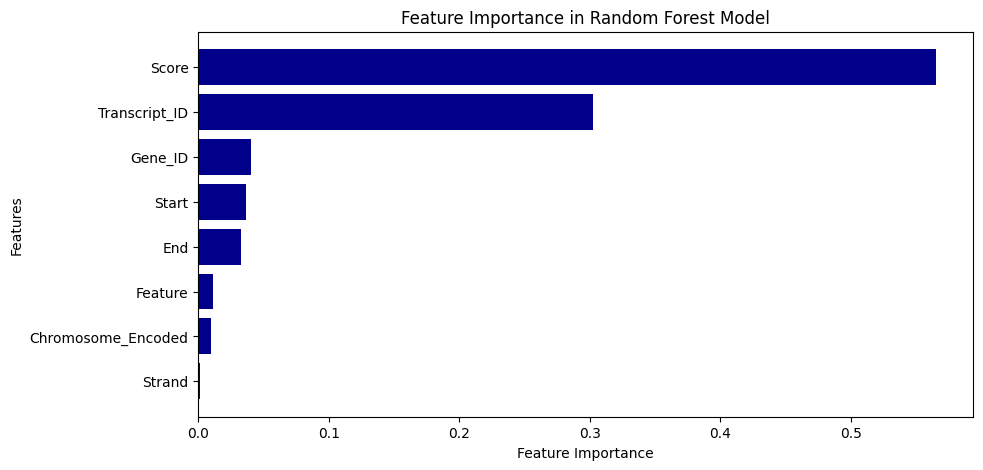

In [4]:
import pandas as pd

# Get feature importance from the best estimator
best_rf = g_search_RF.best_estimator_
feature_importance = best_rf.feature_importances_

# Create a DataFrame for sorting
feat_importance_df = pd.DataFrame({"Feature": X_Train.columns, "Importance": feature_importance})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)  # Sort in descending order

# Print feature importance
print(feat_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df["Feature"], feat_importance_df["Importance"], color='darkblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()
